## The Main Code (one skill) for my Macro Paper
- Author: Junseok Lee (koileekr@snu.ac.kr)
- Last update: Apr 16, 2021
- Goal 1: model heterogeneous aggregate shocks
- Goal 2: find a mechanism that generates a large local mass around the reservation wages
- The belows are currenty preliminary results. (I only calculate the steady state.)

In [629]:
using Plots, NLsolve, Roots, Interpolations, Optim, Random, Images, Dierckx, DataFrames, CSV
using Parameters, QuantEcon, Distributions, StatsBase, Statistics, ProgressBars

### External Parameters

In [2]:
const α = 0.64 # labor share
const γ = 0.4 # intensive Frish elasticity
const hbar = 1/3 # hours worked
const amin = 0 # asset lower bound
const curv = 1.7 # asset grid curvature
const δ = 0.025 # depreciation ratio (quarterly)
const ρx = 0.929 # persistence of labor productivity shocks (Chang and Kim 2006)
const σx = 0.227 # volatility of labor productivity shocks (Chang and Kim 2006)

0.227

### Target Moments (CPS 2019.Q4)
- Employment Rate = 0.79 by `B` (disutility)
- Interest rate = 0.01 by `β` (time discount rate)

In [3]:
Data_emp = 0.79 # unskilled employment rate
Data_rate = 1.00; # interate rate

In [90]:
function TV(VE::Array{Float64,2}, VN::Array{Float64,2},
        w::Float64, r::Float64, β::Float64,
        na::Int64, nz::Int64, B::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2};
        compute_policy=false)
    """
    Update Each Value Function by Optimzation
    Notation: E (Employment), N (Not Working)
    """
    TVE = zeros(na,nz)
    TVN = zeros(na,nz)
    
    if compute_policy
        AS = zeros(na,nz)
        HR = zeros(na,nz)
        CS = zeros(na,nz)
    end
        
    VE′s = [LinearInterpolation(agrid, VE[:,iz]) for iz in 1:nz]
    VN′s = [LinearInterpolation(agrid, VN[:,iz]) for iz in 1:nz]

    for (iz, ez) in enumerate(ezgrid)

        objE = (a′ -> log(w * ez * hbar + (1 + r) * a - a′ + eps()) - B * hbar ^ (1+1/γ) / (1+1/γ)
            + β * (sum([max(VE′(a′), VN′(a′)) for (VE′, VN′) in zip(VE′s, VN′s)], weights(Π[iz,:]))) for a in agrid)
        objN = (a′ -> log((1 + r) * a - a′+ eps())
            + β * (sum([max(VE′(a′), VN′(a′)) for (VE′, VN′) in zip(VE′s, VN′s)], weights(Π[iz,:]))) for a in agrid)

        resultsE = maximize.(objE, amin, min.((w * ez * hbar) .+ (1 + r) .* agrid, amax))
        resultsN = maximize.(objN, amin, min.((1 + r) .* agrid, amax))

        TVE[:,iz] = Optim.maximum.(resultsE)
        TVN[:,iz] = Optim.maximum.(resultsN)

        if compute_policy

            for (ia, a) in enumerate(agrid)

                if TVE[ia,iz] >= TVN[ia,iz]
                    AS[ia,iz] = Optim.maximizer(resultsE[ia])
                    HR[ia,iz] = hbar
                    CS[ia,iz] = w * ez * hbar + (1 + r) * a - AS[ia,iz]
                else
                    AS[ia,iz] = Optim.maximizer(resultsN[ia])
                    HR[ia,iz] = 0.0
                    CS[ia,iz] = (1 + r) * a - AS[ia,iz]
                end
            end
        end
    end
    
    if compute_policy
        return TVE, TVN, AS, HR, CS
    end
    return TVE, TVN
end

TV (generic function with 1 method)

In [91]:
function VFI(init_VE::Array{Float64,2}, init_VN::Array{Float64,2},
        w::Float64, r::Float64, β::Float64,
        na::Int64, nz::Int64, B::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2}, TV;
        max_iter = 1e10, tol = 1e-5)
    """
    Value Function Iteration
    """
    println("VFI")
    VE = init_VE
    VN = init_VN
    for iter in 0:max_iter
        TVE, TVN = TV(VE, VN, w, r, β, na, nz, B, amax, agrid, ezgrid, Π)
        diff = maximum(abs.(TVE .- VE)) + maximum(abs.(TVN .- VN))
        if diff < tol
            return TVE, TVN
        else
            if iter % 500 == 0
                println(diff)
            end
            VE = TVE
            VN = TVN
        end
    end
    println("Not Converged!")
end;

In [92]:
function Tμ(μ::Array{Float64,2}, AS::Array{Float64,2}, na::Int64, nz::Int64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2})
    """
    Update Each Discretized PDF(μ)
    """
    μ′ = zeros(na,nz)
    for iz in 1:nz
        for ia in 1:na
            ia′h = findfirst(a′-> a′ > AS[ia,iz], agrid)
            if ia′h == nothing
                μ′[end,:] .+= μ[ia,iz] .* Π[iz,:]
            else
                ia′l = ia′h - 1
                wgt = (agrid[ia′h]-AS[ia,iz]) / (agrid[ia′h]-agrid[ia′l])
                μ′[ia′l,:] .+= μ[ia,iz] .* Π[iz,:] * wgt
                μ′[ia′h,:] .+= μ[ia,iz] .* Π[iz,:] * (1-wgt)
            end
        end
    end
    return μ′
end;

In [93]:
function μFI(init_μ::Array{Float64,2}, AS::Array{Float64,2}, na::Int64, nz::Int64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2}, Tμ;
        max_iter=10e10, tol=1e-6)
    """
    PDF(μ) Iteration
    """
    println("μFI")
    μ = init_μ
    for iter in 1:max_iter
        μ′ = Tμ(μ, AS, na, nz, agrid, ezgrid, Π)
        diff = maximum(abs.(μ′ .- μ))
        if diff < tol
            return μ′
        else
            if iter % 1000 == 0
                println(diff)
            end
            μ = μ′
        end
    end
    println("Not Converged!")
end;

In [94]:
function findLK(init_VE::Array{Float64,2}, init_VN::Array{Float64,2},
        init_μ::Array{Float64,2}, L::Float64, K::Float64,
        β::Float64, na::Int64, nz::Int64, B::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2},
        TV, VFI, Tμ, μFI)
    """
    Find Aggregate Labor and Capital given τ using a Shooting Algorithm 
    """
    println("finkLK")
    w = α * (K/L) ^ (1-α)
    rmax = 1 / β - 1 - eps()
    rmin = - δ + eps()
    r = min(max((1 - α) * (L / K) ^ α - δ, rmin), rmax)
    
    VE, VN = VFI(init_VE, init_VN, w, r, β, na, nz, B, amax, agrid, ezgrid, Π, TV)
    VE, VN, AS, HR, CS = TV(VE, VN, w, r, β, na, nz, B, amax, agrid, ezgrid, Π; compute_policy=true)
    μ = μFI(init_μ, AS, na, nz, agrid, ezgrid, Π, Tμ)
    println(r)
    L′ = sum([ez * sum(μ[:,iz] .* HR[:,iz]) for (iz, ez) in enumerate(ezgrid)])
    K′ = sum([sum(μ[ia,:] .* a) for (ia, a) in enumerate(agrid)])
    Kd = fzero(K′ -> (1 - α) * (L′/K′) ^ α - r - δ, 1)
    println(K′)
    println(Kd)
    return VE, VN, AS, HR, CS, μ, L′, K′, Kd
end;

In [102]:
function SteadyState(init_VE::Array{Float64,2}, init_VN::Array{Float64,2},
        init_μ::Array{Float64,2}, init_L::Float64, init_K::Float64,
        β::Float64, na::Int64, nz::Int64, B::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2},
        TV, VFI, Tμ, μFI, findLK;
        max_iter=1e10, tol=0.001,
        convex_combi::Float64=0.05, shrink_factor::Float64=0.5,
        expand_factor::Float64=1.1, damp_min::Float64=0.02)
    """
    Find Aggregate Labor and Capital given τ using a Shooting Algorithm
    """
    VE = init_VE
    VN = init_VN
    μ = init_μ
    L = init_L
    K = init_K
    damp = convex_combi
    diff = Inf
    
    for iter in 1:max_iter
        println("L = $(round(L, digits=16))")
        println("K = $(round(K, digits=16))")
        println("------------------------------------------------------")
        VE, VN, AS, HR, CS, μ, L′, K′, Kd = findLK(
            VE, VN, μ, L, K, β, na, nz, B,
            amax, agrid, ezgrid, Π, TV, VFI, Tμ, μFI)
        
        diff′ = abs(L′ - L) / L + abs(K′ - K) / K + abs(Kd - K) / K
        
        if diff′ < tol
            return VE, VN, AS, HR, CS, μ, L′, K′
        else
            # Adjust a dampening factor
            if diff′ > diff
                damp = max(damp * shrink_factor, damp_min)
            else
                damp = min(damp * expand_factor, 0.97)
            end
            
            L = L * (1.0 - damp) + L′ * damp
            K = K * (1.0 - damp) + (K′+ Kd) / 2 * damp
            
            emp = sum(μ .* (HR .> 0))
            rate = (1 - α) * (L / K) ^ α - δ
            
            println("------------------------------------------------------")
            println("dampening factor: $(round(damp, digits=8))")
            println("current difference: $(round(diff′, digits=8))")
            println("current emp : $(round(emp, digits=8))")
            println("current rate: $(round(rate*100, digits=8))")
            println("------------------------------------------------------")
            
        end
        diff = diff′
    end
end;

In [167]:
β = 0.988987; # irate = 1.00%
B = 148.0 # unskilled emp rate = 0.79

# Asset
amax = 40.0;
na = 51 # number of asset grids
agrid = [amin + amax * ((ia-1)/(na-1)) ^ curv for ia in 1:na];

# Productivity
nz = 31 # number of labor prod shocks
ezgrid = exp.(range(-3 * σx, 3 * σx, length = nz));
mc = tauchen(nz, ρx, σx * sqrt(1 - ρx ^ 2), 0);
Π = mc.p;
SSprob = stationary_distributions(mc)[1];

In [114]:
init_VE = zeros(na,nz)
init_VN μeros(na,nz)
init_μ = repeat(transpose(SSprob), na) / na
init_L = 0.2866774560293644
init_K = 11.049371405368259

10.620134555612857

In [168]:
init_VE = VE
init_VN = VN
init_μ = μ
init_L = L
init_K = K;

In [169]:
@time VE, VN, AS, HR, CS, μ, L, K = SteadyState(init_VE, init_VN, init_μ, init_L, init_K,
    β, na, nz, B, amax, agrid, ezgrid, Π, TV, VFI, Tμ, μFI, findLK; tol = 0.01, convex_combi=0.05);

L = 0.2863066423706012
K = 10.800116302842786
------------------------------------------------------
finkLK
VFI
0.012526345402910977
μFI
0.010259846342561052
11.73577534330131
10.671580177707892
------------------------------------------------------
dampening factor: 0.055
current difference: 0.11043689
current emp : 0.7820884
current rate: 1.01987935
------------------------------------------------------
L = 0.2861192331801968
K = 10.822312183014185
------------------------------------------------------
finkLK
VFI
0.005007128655037718
μFI
0.010198793497283969
11.664084795331776
10.679855870359187
------------------------------------------------------
dampening factor: 0.0605
current difference: 0.10410763
current emp : 0.78043239
current rate: 1.01369098
------------------------------------------------------
L = 0.2858913752917826
K = 10.84346650107898
------------------------------------------------------
finkLK
VFI
0.005056786800047064
μFI
0.010136909840802066
11.150063032397956
10.

In [170]:
w = α * (K/L) ^ (1-α)
Model_emp = sum(μ .* (HR .> 0))
Model_rate = (1 - α) * (L / K) ^ α - δ;

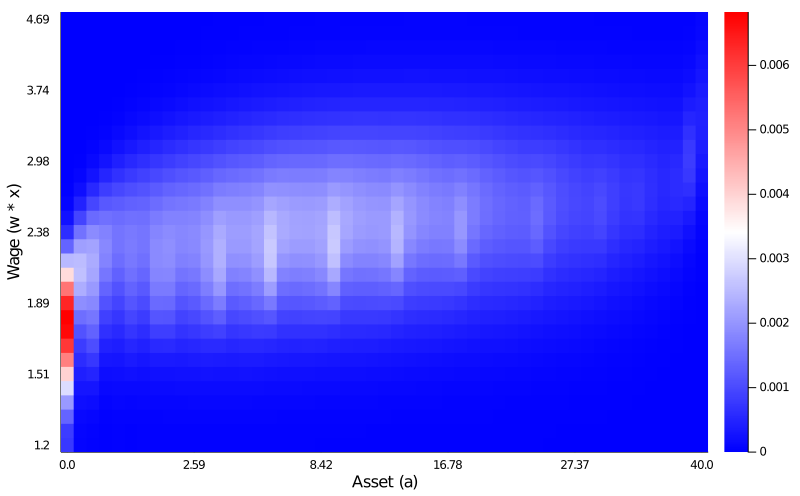

In [171]:
heatmap(transpose(μ), c=cgrad([:blue, :white, :red]), xlabel = "Asset (a)", ylabel = "Wage (w * x)",
    yticks=(1:5:nz, round.(w .* ezgrid[1:5:nz], digits=2)),
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), size=(na*7.85*2,nz*8*2))

In [172]:
println("================[Data VS Model]=================")
println("Emp            : (Model) $(round(Model_emp, digits=2))   VS   (Data) $Data_emp")
println("Interate Rate  : (Model) $(round(Model_rate*100, digits=2))    VS   (Data) $Data_rate")

================[Data VS Model]=================
Emp            : (Model) 0.79   VS   (Data) 0.79
Interate Rate  : (Model) 1.0    VS   (Data) 1.0


### Steady State Moment (just check distribution)

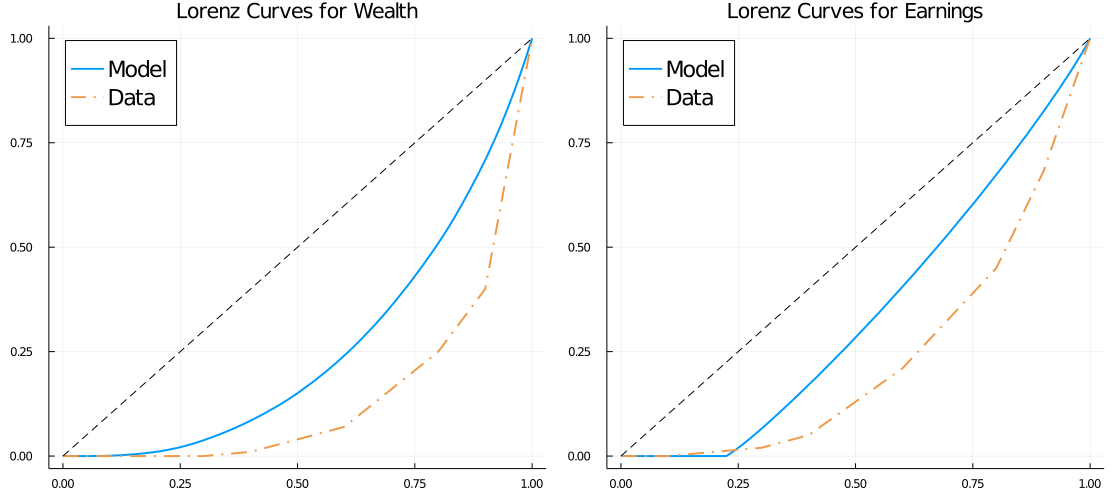

In [653]:
Data_Lorenza = [0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.07, 0.16, 0.25, 0.4, 1.0];
Data_Lorenze = [0.0, 0.0, 0.01, 0.02, 0.05, 0.13, 0.21, 0.33, 0.45, 0.68, 1.0];

smps = [sample(1:na, weights(μ[:,iz]./sum(μ[:,iz])), floor(Int32, SSprob[iz]*1000)) for iz in 1:nz]
wlth = sort([agrid[ia] for smp in smps for ia in smp])
earn = sort([w * ezgrid[iz] * HR[ia,iz] for (iz, smp) in enumerate(smps) for ia in smp])
lorenz = DataFrame(wlth=wlth, earn=earn)
CSV.write("./lorenz_one.csv", lorenz);

l = @layout [a b]
p1 = plot(range(0.0,1.0,length=length(wlth)), cumsum(wlth) ./ sum(wlth),
    legend=:topleft, legendfontsize=15, label="Model", lw=2, title="Lorenz Curves for Wealth")
plot!(p1, 0.0:0.1:1.0, Data_Lorenza, linestyle=:dashdot, label="Data", lw=2, color=:tan2)
plot!(p1, 0:0.1:1, 0:0.1:1, color=:black, lw=1, label="", linestyle=:dash)

p2 = plot(range(0.0,1.0,length=length(earn)), cumsum(earn) ./ sum(earn),
    legend=:topleft, legendfontsize=15, label="Model", lw=2, title="Lorenz Curves for Earnings")
plot!(p2, 0.0:0.1:1.0, Data_Lorenze, linestyle=:dashdot, label="Data", lw=2, color=:tan2)
plot!(p2, 0:0.1:1, 0:0.1:1, color=:black, lw=1, label="", linestyle=:dash)
plot(p1, p2, size=(nz*18*2,nz*8*2), fmt=:png)

In [ ]:
# reservation wage index
rw = [findfirst(x->x>0, transpose(HR)[:,ia]) for ia in 1:na];
rw[findall(x->x==nothing,rw)] .= nz

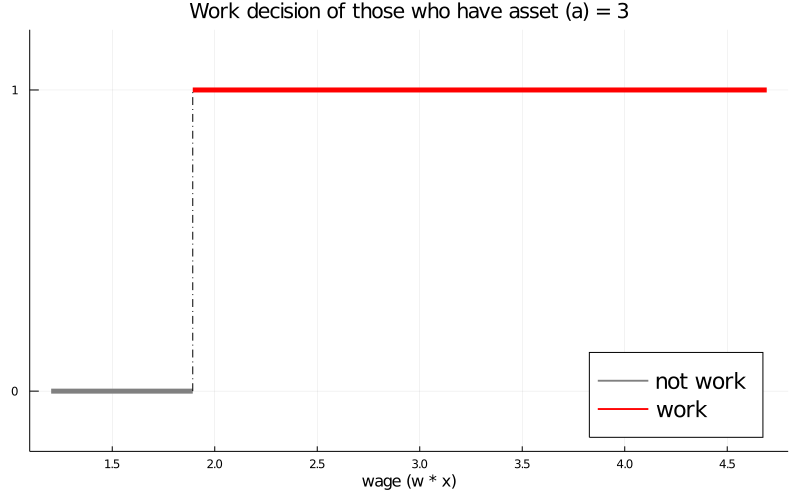

In [224]:
plot(w.*ezgrid[1:rw[12]], zeros(rw[12]), color=:gray, lw=5, ylim=(-0.2, 1.2), label="not work", fmt=:png, size=(na*7.85*2,nz*8*2),
    legendfontsize=15, legend=:bottomright, xlabel="wage (w * x)", yticks=[0,1], title="Work decision of those who have asset (a) = 3")
plot!(w.*ezgrid[rw[12]:end], ones(nz-rw[12]+1), color=:red, lw=5, label="work")
plot!(w.*[ezgrid[rw[12]],ezgrid[rw[12]]], [0,1], linestyle=:dashdot, color=:black, label=:none)

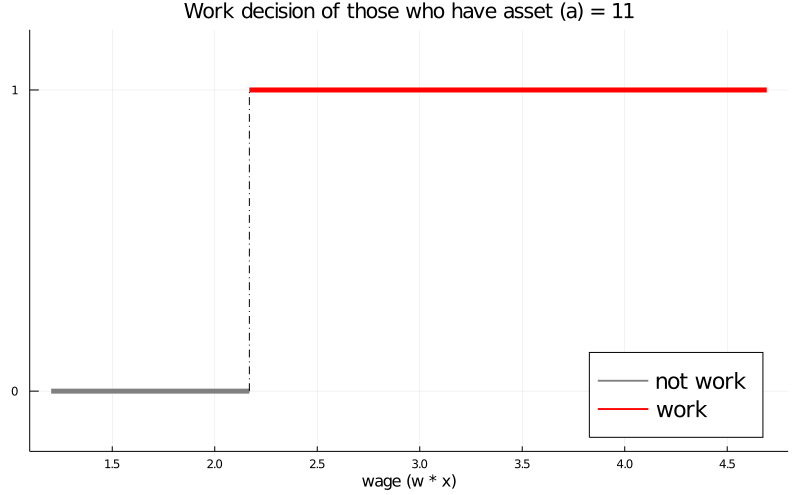

In [225]:
plot(w.*ezgrid[1:rw[24]], zeros(rw[24]), color=:gray, lw=5, ylim=(-0.2, 1.2), label="not work", fmt=:png, size=(na*7.85*2,nz*8*2), 
    legendfontsize=15, legend=:bottomright, xlabel="wage (w * x)", yticks=[0,1], title="Work decision of those who have asset (a) = 11")
plot!(w.*ezgrid[rw[24]:end], ones(nz-rw[24]+1), color=:red, lw=5, label="work")
plot!(w.*[ezgrid[rw[24]],ezgrid[rw[24]]], [0,1], linestyle=:dashdot, color=:black, label=:none)

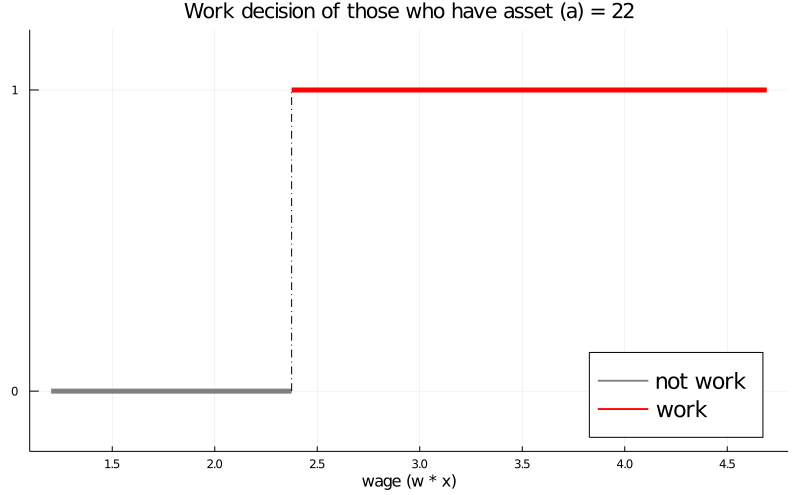

In [226]:
plot(w.*ezgrid[1:rw[36]], zeros(rw[36]), color=:gray, lw=5, ylim=(-0.2, 1.2), label="not work", fmt=:png, size=(na*7.85*2,nz*8*2), 
    legendfontsize=15, legend=:bottomright, xlabel="wage (w * x)", yticks=[0,1], title="Work decision of those who have asset (a) = 22")
plot!(w.*ezgrid[rw[36]:end], ones(nz-rw[36]+1), color=:red, lw=5, label="work")
plot!(w.*[ezgrid[rw[36]],ezgrid[rw[36]]], [0,1], linestyle=:dashdot, color=:black, label=:none)

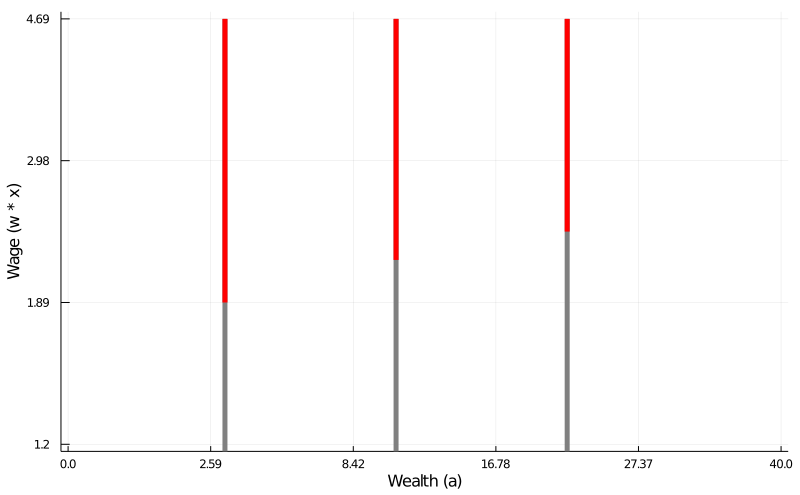

In [229]:
plot(color=:black, lw=5, label="Reservation Wage", legend=:bottomright, legendfontsize=15, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
#scatter!([15], [41], label="A", markersize=8, color=:tan1)
#scatter!([15], [25], label="B", markersize=8, color=:lime)
#scatter!([65], [41], label="B", markersize=8, color=:maroon1)

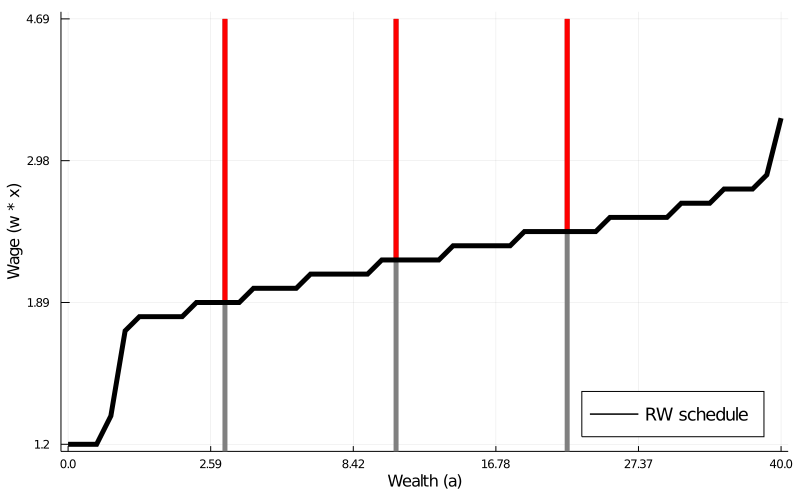

In [272]:
plot(legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")

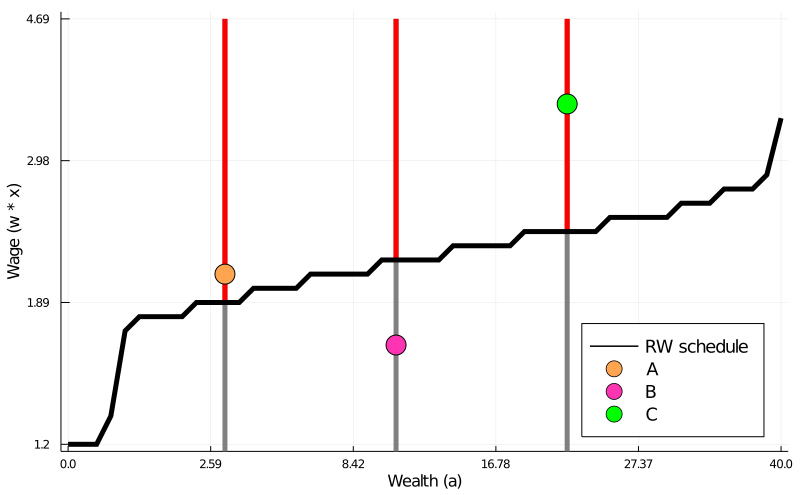

In [306]:
plot(legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")
scatter!([12], [13], label="A", markersize=12, color=:tan1)
scatter!([24], [8], label="B", markersize=12, color=:maroon1)
scatter!([36], [25], label="C", markersize=12, color=:lime)

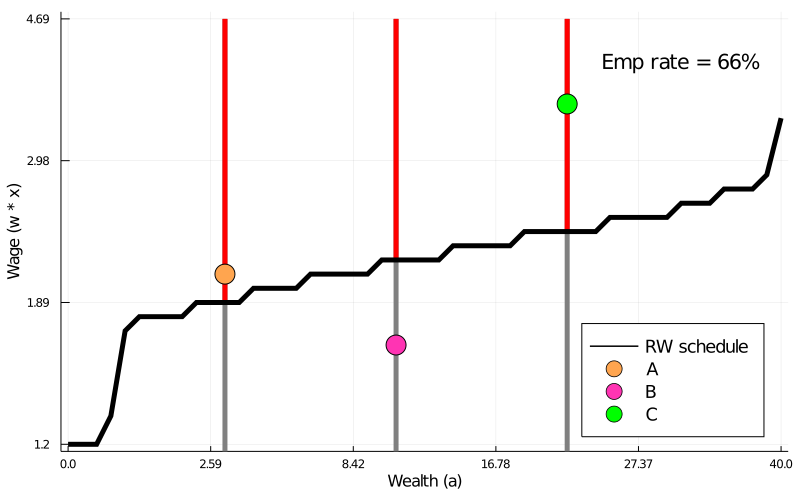

In [305]:
plot(legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")
scatter!([12], [13], label="A", markersize=12, color=:tan1)
scatter!([24], [8], label="B", markersize=12, color=:maroon1)
scatter!([36], [25], label="C", markersize=12, color=:lime)
annotate!(44, 28, "Emp rate = 66%")

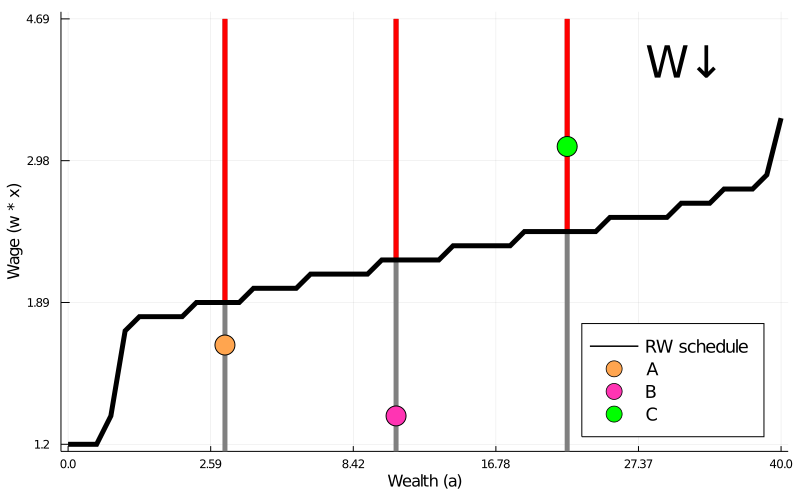

In [304]:
plot(legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")
scatter!([12], [8], label="A", markersize=12, color=:tan1)
scatter!([24], [3], label="B", markersize=12, color=:maroon1)
scatter!([36], [22], label="C", markersize=12, color=:lime)
annotate!(44, 28, text("W↓",:black, 30))

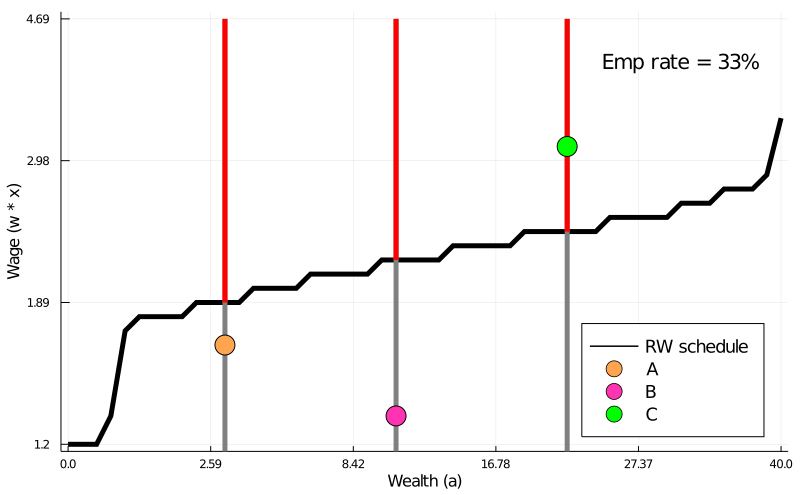

In [303]:
plot(1:na, rw, color=:black, lw=5, label="RW schedule", legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
scatter!([12], [8], label="A", markersize=12, color=:tan1)
scatter!([24], [3], label="B", markersize=12, color=:maroon1)
scatter!([36], [22], label="C", markersize=12, color=:lime)
annotate!(44, 28, "Emp rate = 33%")

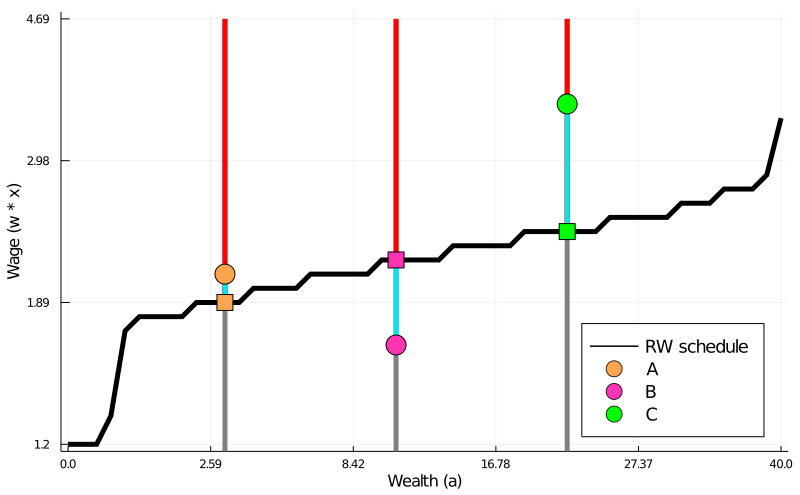

In [302]:
plot(legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([12, 12], [rw[12],13], color=:turquoise2, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([24, 24], [8,rw[24]], color=:turquoise2, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
plot!([36, 36], [rw[36],25], color=:turquoise2, lw=5, label="")
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")
scatter!([12], [13], label="A", markersize=12, color=:tan1)
scatter!([12], [rw[12]], label="", markersize=8, color=:tan1, marker=:square)
scatter!([24], [8], label="B", markersize=12, color=:maroon1)
scatter!([24], [rw[24]], label="", markersize=8, color=:maroon1, marker=:square)
scatter!([36], [25], label="C", markersize=12, color=:lime)
scatter!([36], [rw[36]], label="", markersize=8, color=:lime, marker=:square)

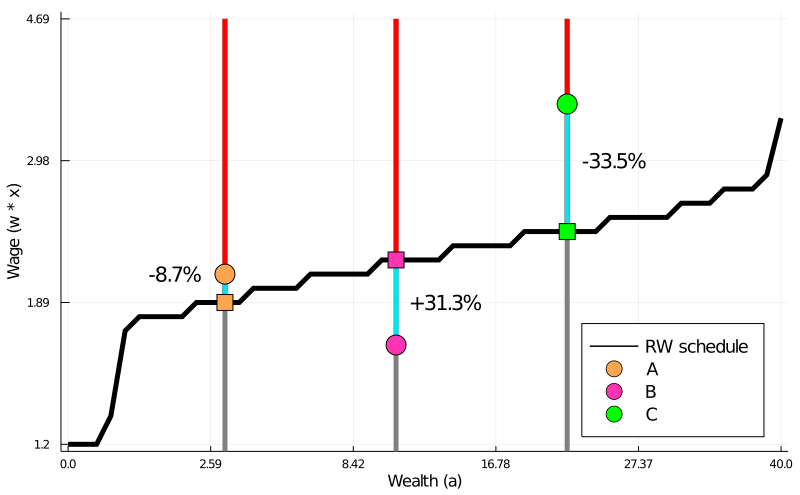

In [334]:
plot(legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!([12, 12], [0,nz], color=:gray, lw=5, label="")
plot!([12, 12], [rw[12],nz], color=:red, lw=5, label="")
plot!([12, 12], [rw[12],13], color=:turquoise2, lw=5, label="")
plot!([24, 24], [0,nz], color=:gray, lw=5, label="")
plot!([24, 24], [rw[24],nz], color=:red, lw=5, label="")
plot!([24, 24], [8,rw[24]], color=:turquoise2, lw=5, label="")
plot!([36, 36], [0,nz], color=:gray, lw=5, label="")
plot!([36, 36], [rw[36],nz], color=:red, lw=5, label="")
plot!([36, 36], [rw[36],25], color=:turquoise2, lw=5, label="")
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")
scatter!([12], [13], label="A", markersize=12, color=:tan1)
scatter!([12], [rw[12]], label="", markersize=8, color=:tan1, marker=:square)
scatter!([24], [8], label="B", markersize=12, color=:maroon1)
scatter!([24], [rw[24]], label="", markersize=8, color=:maroon1, marker=:square)
scatter!([36], [25], label="C", markersize=12, color=:lime)
scatter!([36], [rw[36]], label="", markersize=8, color=:lime, marker=:square)
annotate!(8.5, 13, "-8.7%")
annotate!(27.5, 11, "+31.3%")
annotate!(39.3, 21, "-33.5%")

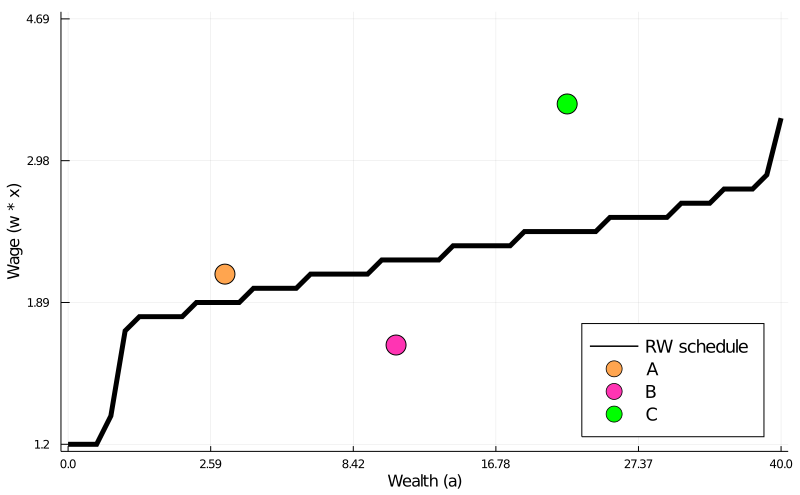

In [337]:
plot(legend=:bottomright, legendfontsize=12, size=(na*7.85*2,nz*8*2),
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)", xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5)) 
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")
scatter!([12], [13], label="A", markersize=12, color=:tan1)
scatter!([24], [8], label="B", markersize=12, color=:maroon1)
scatter!([36], [25], label="C", markersize=12, color=:lime)

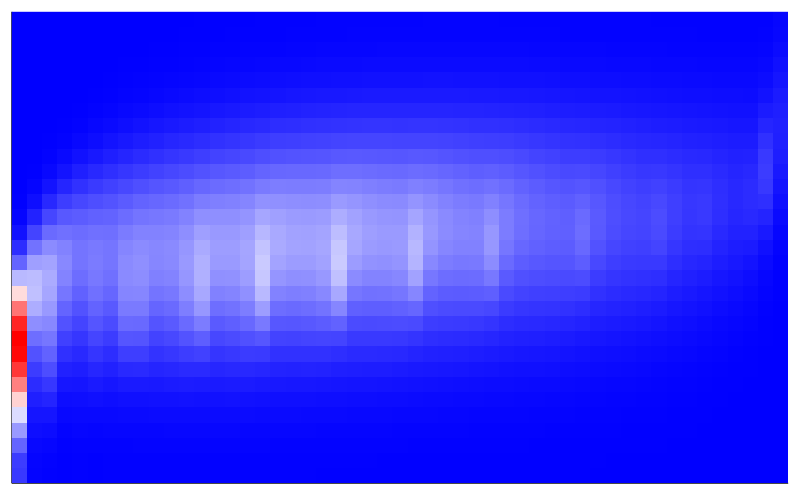

In [339]:
heatmap(transpose(μ), c=cgrad([:blue, :white, :red]), xlabel="",ylabel="",xticks=:none,yticks=:none, fmt=:png, cbar=:none, size=(na*7.85*2,nz*8*2))

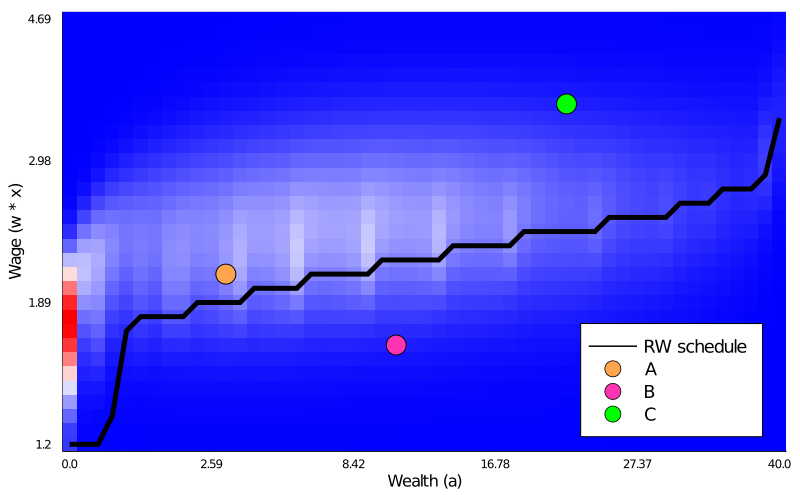

In [342]:
a = load("mu.png")
b = imresize(a, nz, na);
plot(b, yflip=false, xlim=(0.5,na+0.5), ylim=(0.5,nz+0.5), size=(na*7.85*2,nz*8*2), legend=:bottomright, legendfontsize=12,
    yticks=(1:10:nz, round.(w .* ezgrid[1:10:nz],digits=2)), ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)")
plot!(1:na, rw, color=:black, lw=5, label="RW schedule")
scatter!([12], [13], label="A", markersize=12, color=:tan1)
scatter!([24], [8], label="B", markersize=12, color=:maroon1)
scatter!([36], [25], label="C", markersize=12, color=:lime)

In [196]:
# reservation raise
RR = zeros(na,nz);
for ia in 1:na
    for iz in 1:nz
        RR[ia,iz] = (ezgrid[rw[ia]]-ezgrid[iz]) / ezgrid[iz]
    end
end

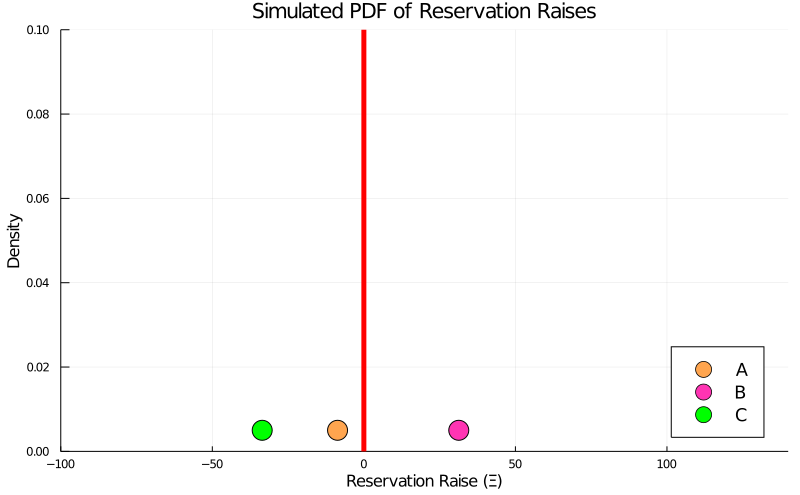

In [431]:
lbd = -1.0
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, RRdist)
plot(xlabel="Reservation Raise (Ξ)", ylabel="Density", xlim=(rrgrid[1], rrgrid[end]), ylim=(0,0.1),
    size=(na*7.85*2,nz*8*2), title="Simulated PDF of Reservation Raises", fmt=:png, legend=:bottomright, legendfontsize=12)
scatter!([100*(ezgrid[rw[12]]-ezgrid[13]) / ezgrid[13]], [0.005], label="A", markersize=12, color=:tan1)
scatter!([100*(ezgrid[rw[24]]-ezgrid[8]) / ezgrid[8]], [0.005], label="B", markersize=12, color=:maroon1)
scatter!([100*(ezgrid[rw[36]]-ezgrid[25]) / ezgrid[25]], [0.005], label="C", markersize=12, color=:lime)
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)

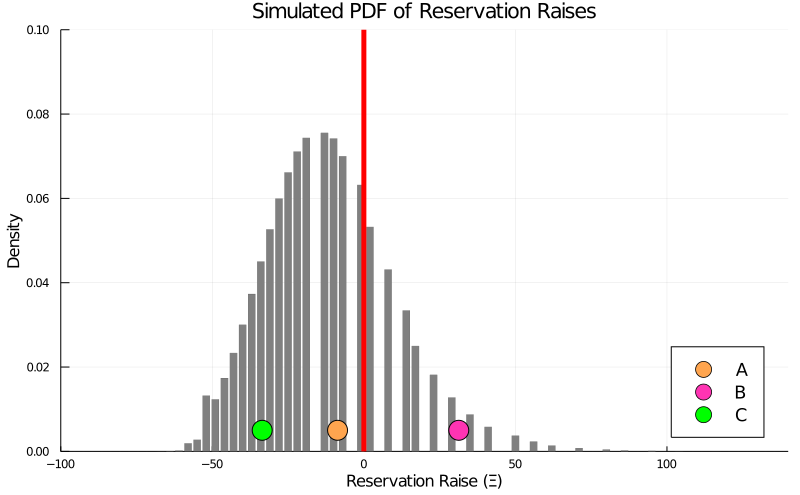

In [430]:
lbd = -1.0
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, RRdist)
plot(xlabel="Reservation Raise (Ξ)", ylabel="Density", xlim=(rrgrid[1], rrgrid[end]), ylim=(0,0.1),
    size=(na*7.85*2,nz*8*2), title="Simulated PDF of Reservation Raises", fmt=:png, legend=:bottomright, legendfontsize=12)
bar!(rrgrid, RRdist, label="", color="gray", lw=0.1)
scatter!([100*(ezgrid[rw[12]]-ezgrid[13]) / ezgrid[13]], [0.005], label="A", markersize=12, color=:tan1)
scatter!([100*(ezgrid[rw[24]]-ezgrid[8]) / ezgrid[8]], [0.005], label="B", markersize=12, color=:maroon1)
scatter!([100*(ezgrid[rw[36]]-ezgrid[25]) / ezgrid[25]], [0.005], label="C", markersize=12, color=:lime)
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)

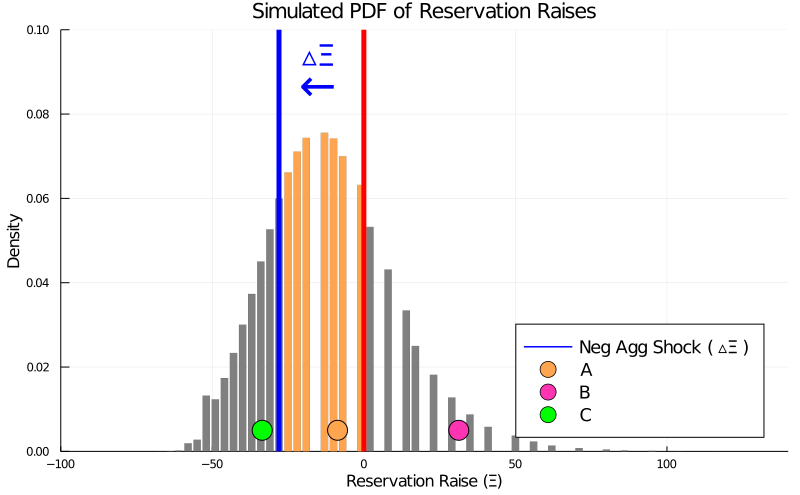

In [465]:
lbd = -1.0
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, RRdist)
plot(xlabel="Reservation Raise (Ξ)", ylabel="Density", xlim=(rrgrid[1], rrgrid[end]), ylim=(0,0.1),
    size=(na*7.85*2,nz*8*2), title="Simulated PDF of Reservation Raises", fmt=:png, legend=:bottomright, legendfontsize=12)
bar!(rrgrid[findall(r->-28.0<r<=0, rrgrid)], RRdist[findall(r->-28.0<r<=0, rrgrid)], label="", color="tan1", lw=0.1)
bar!(rrgrid[findall(r->r<=-28.0, rrgrid)], RRdist[findall(r->r<=-28.0, rrgrid)], label="", color="gray", lw=0.1)
bar!(rrgrid[findall(r->r>0.0, rrgrid)], RRdist[findall(r->r>-0.0, rrgrid)], label="", color="gray", lw=0.1)
plot!([-28.0,-28.0],[0.0,1.0], label="Neg Agg Shock ( ▵Ξ )", color="blue", lw=5)
scatter!([100*(ezgrid[rw[12]]-ezgrid[13]) / ezgrid[13]], [0.005], label="A", markersize=12, color=:tan1)
scatter!([100*(ezgrid[rw[24]]-ezgrid[8]) / ezgrid[8]], [0.005], label="B", markersize=12, color=:maroon1)
scatter!([100*(ezgrid[rw[36]]-ezgrid[25]) / ezgrid[25]], [0.005], label="C", markersize=12, color=:lime)
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)
annotate!(-15.3, 0.094, text("▵Ξ",:blue, 20))
annotate!(-15.3, 0.087, text("←",:blue, 30))

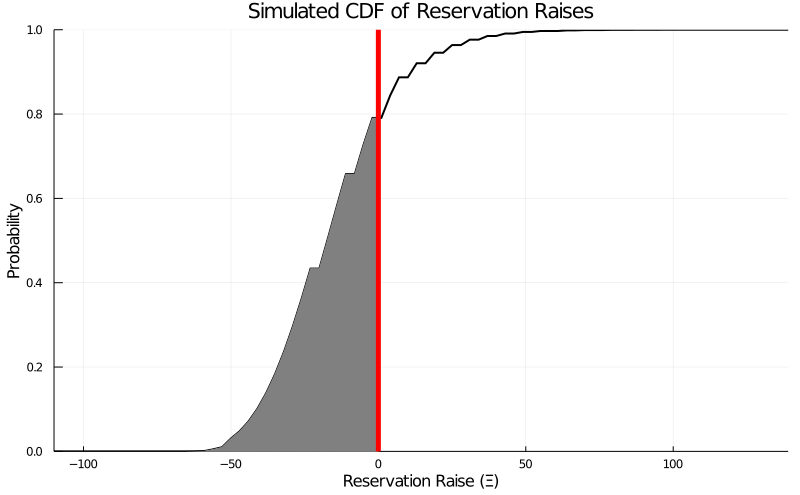

In [427]:
lbd = -1.1
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, cumsum(RRdist))
plot(rrgrid, cumsum(RRdist), xlabel="Reservation Raise (Ξ)", ylabel="Probability",
    ylim=(0,1.0), label="", color="black", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]), size=(na*7.85*2,nz*8*2))
for r in rrgrid2
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:gray, label="")
end
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)

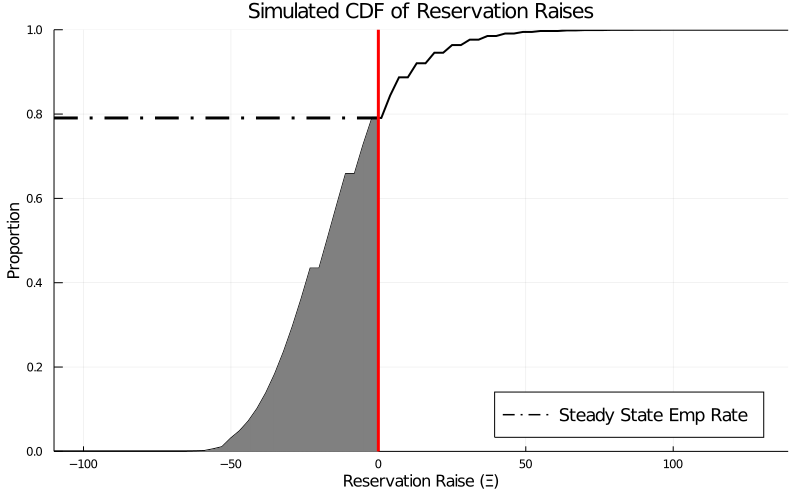

In [428]:
lbd = -1.1
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, cumsum(RRdist))
plot(rrgrid, cumsum(RRdist), xlabel="Reservation Raise (Ξ)", ylabel="Proportion",
    ylim=(0,1.0), label="", color="black", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]), size=(na*7.85*2,nz*8*2))
for r in rrgrid2
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:gray, label="")
end
plot!([rrgrid[1],0.0],[RRfunc(0.0),RRfunc(0.0)], linestyle=:dashdot,
    label="Steady State Emp Rate", legend=:bottomright, legendfontsize=12, color=:black, lw=3)
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=3)

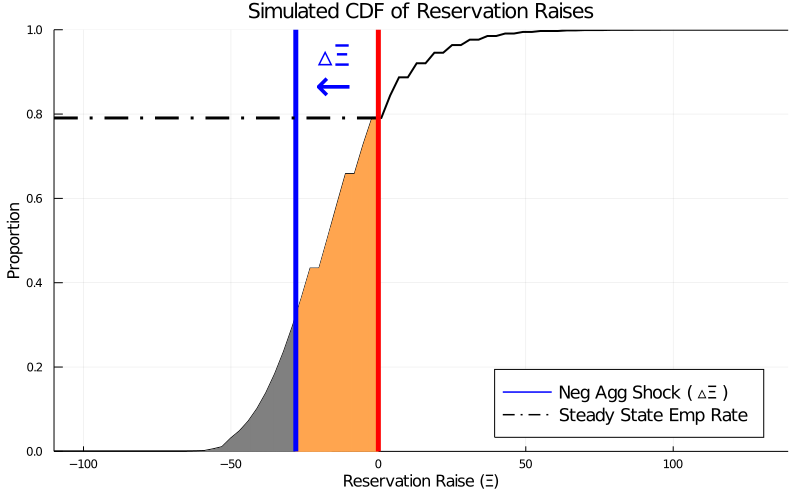

In [436]:
lbd = -1.1
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, cumsum(RRdist))
plot(rrgrid, cumsum(RRdist), xlabel="Reservation Raise (Ξ)", ylabel="Proportion",
    ylim=(0,1.0), label="", color="black", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]), size=(na*7.85*2,nz*8*2))
for r in rrgrid2[1:findlast(r->r<-16.0,rrgrid2)]
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:gray, label="")
end
for r in rrgrid2[findlast(r->r<-28.0,rrgrid2):end]
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:tan1, label="")
end
plot!([-28.0,-28.0],[0.0,1.0], label="Neg Agg Shock ( ▵Ξ )", color="blue", lw=5, legend=:bottomright, legendfontsize=12)
plot!([rrgrid[1],0.0],[RRfunc(0.0),RRfunc(0.0)], linestyle=:dashdot,
    lw=3, color=:black, label="Steady State Emp Rate")
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)
annotate!(-15.3, 0.94, text("▵Ξ",:blue, 20))
annotate!(-15.3, 0.87, text("←",:blue, 30))

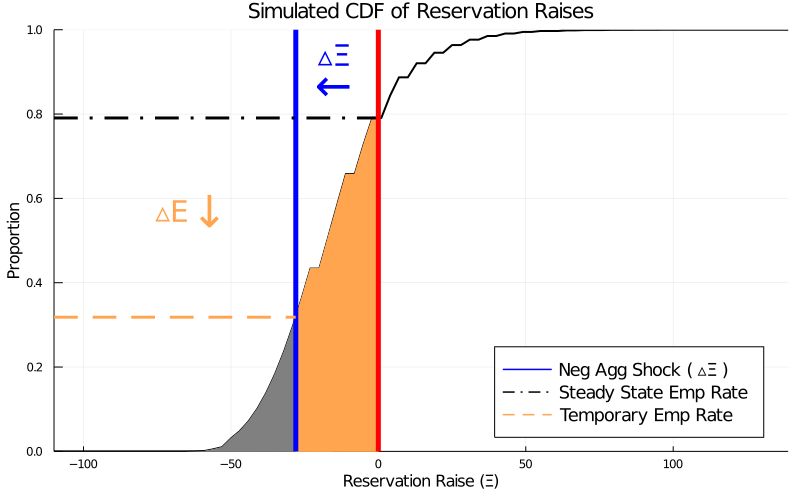

In [437]:
lbd = -1.1
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, cumsum(RRdist))
plot(rrgrid, cumsum(RRdist), xlabel="Reservation Raise (Ξ)", ylabel="Proportion",
    ylim=(0,1.0), label="", color="black", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]), size=(na*7.85*2,nz*8*2))
for r in rrgrid2[1:findlast(r->r<-16.0,rrgrid2)]
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:gray, label="")
end
for r in rrgrid2[findlast(r->r<-28.0,rrgrid2):end]
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:tan1, label="")
end
plot!([-28.0,-28.0],[0.0,1.0], label="Neg Agg Shock ( ▵Ξ )", color="blue", lw=5, legend=:bottomright, legendfontsize=12)
plot!([rrgrid[1],0.0],[RRfunc(0.0),RRfunc(0.0)], linestyle=:dashdot,
    lw=3, color=:black, label="Steady State Emp Rate")
plot!([rrgrid[1],rrgrid2[findlast(r->r<-28.0,rrgrid2)]],[RRfunc(-28.0),RRfunc(-28.0)],
    linestyle=:dash, lw=3, color=:tan1, label="Temporary Emp Rate")
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)
annotate!(-15.3, 0.94, text("▵Ξ",:blue, 20))
annotate!(-15.3, 0.87, text("←",:blue, 30))
annotate!(-70.3, 0.57, text("▵E",:tan1, 20))
annotate!(-57.3, 0.57, text("↓",:tan1, 30))

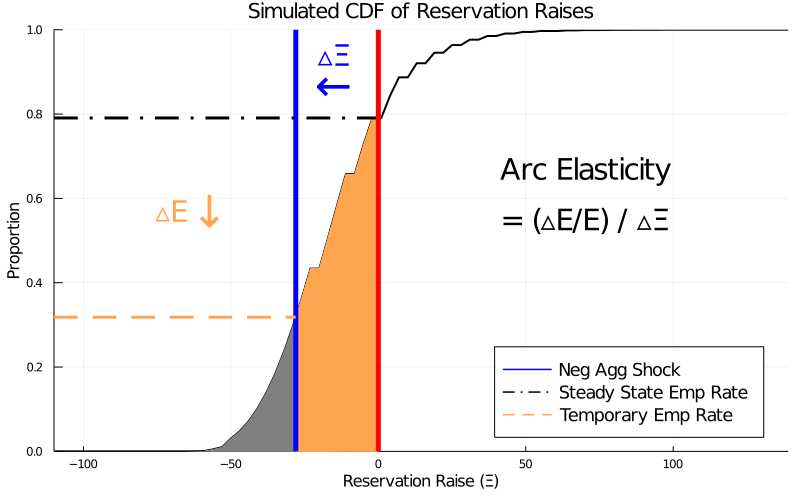

In [452]:
lbd = -1.1
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, cumsum(RRdist))
plot(rrgrid, cumsum(RRdist), xlabel="Reservation Raise (Ξ)", ylabel="Proportion",
    ylim=(0,1.0), label="", color="black", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]), size=(na*7.85*2,nz*8*2))
for r in rrgrid2[1:findlast(r->r<-16.0,rrgrid2)]
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:gray, label="")
end
for r in rrgrid2[findlast(r->r<-28.0,rrgrid2):end]
    plot!([r,r],[0.0,RRfunc(r)], lw=1, color=:tan1, label="")
end
plot!([-28.0,-28.0],[0.0,1.0], label="Neg Agg Shock", color="blue", lw=5, legend=:bottomright, legendfontsize=12)
plot!([rrgrid[1],0.0],[RRfunc(0.0),RRfunc(0.0)], linestyle=:dashdot,
    lw=3, color=:black, label="Steady State Emp Rate")
plot!([rrgrid[1],rrgrid2[findlast(r->r<-28.0,rrgrid2)]],[RRfunc(-28.0),RRfunc(-28.0)],
    linestyle=:dash, lw=3, color=:tan1, label="Temporary Emp Rate")
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)
annotate!(-15.3, 0.94, text("▵Ξ",:blue, 20))
annotate!(-15.3, 0.87, text("←",:blue, 30))
annotate!(-70.3, 0.57, text("▵E",:tan1, 20))
annotate!(-57.3, 0.57, text("↓",:tan1, 30))
annotate!(70.3, 0.67, text("Arc Elasticity",:black, 20))
annotate!(70.3, 0.55, text("= (▵E/E) / ▵Ξ",:black, 20))

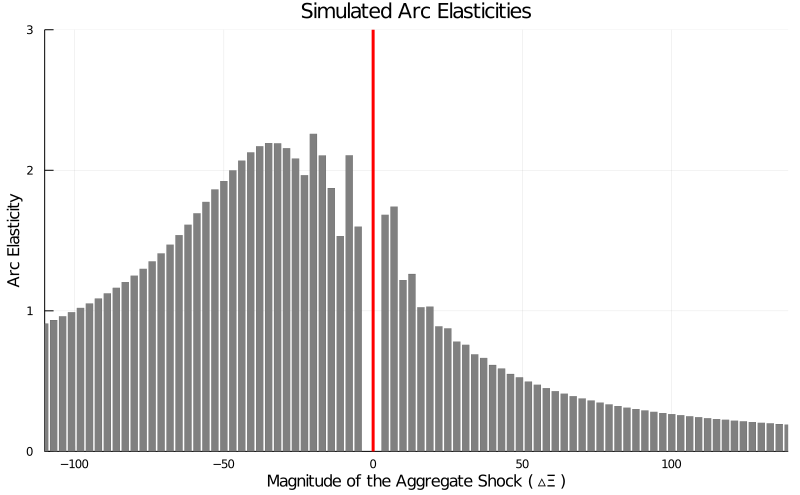

In [457]:
arc = 100 .* ((cumsum(RRdist) .- RRfunc(0.0)) ./ RRfunc(0.0)) ./ rrgrid
bar(rrgrid, arc, color=:gray, lw=0.1, title = "Simulated Arc Elasticities", ylabel="Arc Elasticity",
    label="", ylim=(0,3), xlim=(rrgrid[1], rrgrid[end]), xlabel="Magnitude of the Aggregate Shock ( ▵Ξ )", fmt=:png,
    size=(na*7.85*2,nz*8*2))
plot!([0.0,0.0],[0.0,4.0], label="", color="red", lw=3)

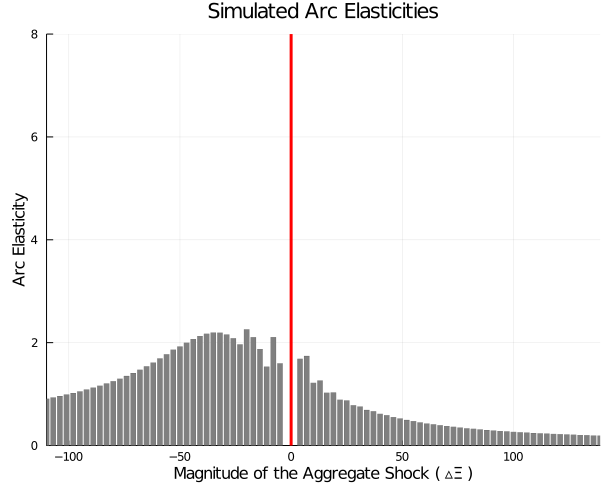

In [460]:
arc = 100 .* ((cumsum(RRdist) .- RRfunc(0.0)) ./ RRfunc(0.0)) ./ rrgrid
bar(rrgrid, arc, color=:gray, lw=0.1, title = "Simulated Arc Elasticities", ylabel="Arc Elasticity",
    label="", ylim=(0,8), xlim=(rrgrid[1], rrgrid[end]), xlabel="Magnitude of the Aggregate Shock ( ▵Ξ )", fmt=:png,
    size=(na*6*2,nz*8*2))
plot!([0.0,0.0],[0.0,8.0], label="", color="red", lw=3)